In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
import seaborn as sns 
import re
 
import warnings # supress warnings
warnings.filterwarnings('ignore')

In [2]:
import sklearn

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, scale, StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.inspection import permutation_importance

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, RationalQuadratic,Exponentiation
from sklearn.gaussian_process.kernels import Kernel, Hyperparameter, ConstantKernel
from sklearn.gaussian_process.kernels import GenericKernelMixin

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score  

from sklearn.pipeline import make_pipeline

from sklearn.base import clone

In [3]:
def run_models():
    #rf = RandomForestRegressor(n_estimators= 100, random_state= 10)
    rf = RandomForestRegressor(n_estimators=10, criterion='absolute_error', 
                               min_samples_split=2, min_samples_leaf=1, max_features=0.3)
    gb = GradientBoostingRegressor(loss='quantile', alpha=0.5,
                                n_estimators=100, max_depth=10,
                                learning_rate=0.25, min_samples_leaf=9,
                                min_samples_split=2)
    rr = Ridge(alpha=0.01)
    lasso = Lasso(alpha=0.02)
    gpr1 = GaussianProcessRegressor(optimizer='fmin_l_bfgs_b',random_state=50,
                                    kernel=DotProduct() + WhiteKernel(),
                                    alpha=0.1, n_restarts_optimizer=1)
    gpr2 = GaussianProcessRegressor(optimizer='fmin_l_bfgs_b',random_state=50,
                                    kernel=1.0 + 1.0 * Exponentiation(RBF(length_scale=1.0), exponent=2) + 
                                    WhiteKernel(noise_level=0.1), alpha=0.1, n_restarts_optimizer=1)
    gpr3 = GaussianProcessRegressor(optimizer='fmin_l_bfgs_b',random_state=50,
                                    kernel=1.0 + 1.0 * Exponentiation(RationalQuadratic(length_scale=1.0, 
                                                                                        alpha=0.01), exponent=2),
                                    alpha=0.001, n_restarts_optimizer=1)
    gpr4 = GaussianProcessRegressor(optimizer='fmin_l_bfgs_b',random_state=50,
                                    kernel=1.0 + 1.0 * Exponentiation(Matern(length_scale=1.0, nu=1.5), exponent=2),
                                    alpha=0.01, n_restarts_optimizer=1)
    models = [rf,gb,rr,lasso,gpr1,gpr2,gpr3,gpr4]
    models_names = ["RF","GB","RR","LASSO","gpr1","gpr2","gpr3","gpr4"]
    r2scores=[]
    rmse=[]
    count=0
    for model in models :
        predicted_y = []
        expected_y = []
        kf = KFold(n_splits= 10) 
        # partition data
        for train_index, test_index in kf.split(X, Y):
            # specific ".loc" syntax for working with dataframes
            x_train, x_test = X.loc[train_index], X.loc[test_index]
            y_train, y_test = Y[train_index], Y[test_index]

            # create and fit classifier
            model.fit(x_train, y_train)

            # store result from classification
            predicted_y.extend(model.predict(x_test))

            # store expected result for this specific fold
            expected_y.extend(y_test)
        
        r2 = metrics.r2_score(expected_y, predicted_y)
        r2scores.append(r2)
        
        err=np.sqrt(metrics.mean_squared_error(expected_y, predicted_y))
        rmse.append(err)
        
        print(models_names[count])
        print("R2: ",r2.__str__())
        print("RMSE: ",err)
        print("---------------------------------------")
        count+=1
    
    plt.rcdefaults()
    fig, ax = plt.subplots()

    x_pos = np.arange(len(models_names))
    ax.bar(x_pos, r2scores, align='center')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(models_names)
    ax.set_ylabel('R2 Score')
    #plt.savefig('imp.eps', format='eps')
    #plt.show()
    print(r2scores)

In [4]:
data = pd.read_csv('Combined_all_3rd_fit.csv', encoding='cp1252')
print(data.columns.values)

['Name' 'Coef_a' 'Coef_b' 'Coef_c' 'Coef_d' 'A_site' 'B_site' 'X_site'
 'Spacegroup' 'Ehull' 'BulkModulus' 'Energy' 'ZPE' 's_A' 's_B' 's_X'
 'density' 'mean_A2B' 'mean_A2X' 'mean_B2X' 'mean_X2X' 'std_A2B' 'std_A2X'
 'std_B2X' 'std_X2X' 'E_coh' 'TF' 'OF' 'A_Z' 'B_Z' 'X_Z' 'A_M' 'B_M' 'X_M'
 'A_G' 'B_G' 'X_G' 'A_IEI' 'B_IEI' 'X_IEI' 'A_IEII' 'B_IEII' 'X_IEII'
 'A_EA' 'B_EA' 'X_EA' 'A_ChiP' 'B_ChiP' 'X_ChiP' 'A_ChiA' 'X_ChiA'
 'A_Rvdw' 'B_Rvdw' 'X_Rvdw' 'A_Rc' 'B_Rc' 'X_Rc' 'A_Ra' 'B_Ra' 'X_Ra'
 'A_MP' 'B_MP' 'X_MP' 'A_BP' 'B_BP' 'X_BP' 'A_Rho' 'B_Rho' 'A_MV' 'B_MV'
 'X_MV' 'A_Hf' 'B_Hf' 'X_Hf' 'A_Hv' 'B_Hv' 'X_Hv' 'A_Kappa' 'B_Kappa'
 'X_Kappa' 'A_CvM' 'B_CvM' 'X_CvM' 'A_B' 'B_B' 'X_B' 'A_MendeleevNo'
 'B_MendeleevNo' 'X_MendeleevNo']


In [5]:
data.drop(['Name', 'A_site', 'B_site', 'X_site', 'Spacegroup','BulkModulus',
           'Ehull','Energy','ZPE','Coef_b', 'Coef_c', 'Coef_d'], axis=1, inplace = True)
target = 'Coef_a'

In [6]:
data.fillna(0, inplace= True)
d=data.copy()
columns = list(d.columns.values)

# Standard Scaling

In [7]:
data_std=d.copy()
scalerSTD=StandardScaler()
scalerSTD.fit(np.array(data[target]).reshape(-1, 1))
data_zpe_std= scalerSTD.transform(np.array(data[target]).reshape(-1, 1))
data_std[columns]= StandardScaler().fit_transform(d[columns])
Y = data_std[target] 
X = data_std.drop([target], axis=1)

In [8]:
correlated_features = ["A_Rc","A_Ra","A_M","A_MP","A_MV","A_MendeleevNo","A_Hf","A_Hv","B_Rc",
                       "B_Rvdw","B_M","B_BP","B_MendeleevNo","B_Hv","X_Rc","X_Rvdw","X_M","X_BP","X_MP",
                       "X_MendeleevNo","X_Hf","X_Hv","X_G","X_B","X_CvM","X_ChiP"]
data_std.drop(labels=correlated_features, axis=1, inplace=True)
print(data_std.shape)
Y = data_std[target] 
X = data_std.drop([target], axis=1)

(80, 51)


In [9]:
#data_std.to_csv("scaled_non_correlated.csv")

### Using CV technique

RF
R2:  0.8514660408956289
RMSE:  0.38540103671937764
---------------------------------------
GB
R2:  0.8242097620002977
RMSE:  0.41927346445929803
---------------------------------------
RR
R2:  -1.0841497830225935
RMSE:  1.4436584717385872
---------------------------------------
LASSO
R2:  0.8079592410400311
RMSE:  0.438224553123132
---------------------------------------
gpr1
R2:  0.36916043022907397
RMSE:  0.7942540964772709
---------------------------------------
gpr2
R2:  0.8713125356966502
RMSE:  0.35873035040730755
---------------------------------------
gpr3
R2:  0.8814756448432871
RMSE:  0.34427366317613217
---------------------------------------
gpr4
R2:  0.8716640231168892
RMSE:  0.3582401106564015
---------------------------------------
[0.8514660408956289, 0.8242097620002977, -1.0841497830225935, 0.8079592410400311, 0.36916043022907397, 0.8713125356966502, 0.8814756448432871, 0.8716640231168892]


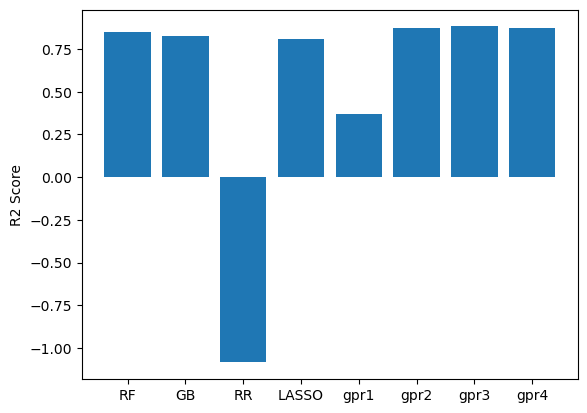

In [10]:
run_models()

## Feature selection


In [11]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

     Feature       Score
4   mean_A2B  135.546281
2        s_X   97.521570
35      X_Ra   88.664521
28      X_EA   87.903070
17       X_Z   87.153415
7   mean_X2X   77.101385
33    A_Rvdw   64.765740
0        s_A   56.272893
5   mean_A2X   54.501373
1        s_B   51.629862
20     A_IEI   41.774757
12     E_coh   36.615505
31    A_ChiA   21.738026
9    std_A2X   19.689607
25    X_IEII   19.320300
42      B_Hf   18.855125
29    A_ChiP   18.434576
36      B_MP   15.078645
37      A_BP   14.590560
10   std_B2X   13.447665
15       A_Z   13.107769
45   X_Kappa   12.936079
26      A_EA   12.189494
34      B_Ra   10.925759
14        OF    9.747189
46     A_CvM    9.336114
16       B_Z    9.046251
43   A_Kappa    8.888579
44   B_Kappa    7.588177
32    X_ChiA    7.287500


In [12]:
featureScores.nlargest(40,'Score')['Feature'].values

array(['mean_A2B', 's_X', 'X_Ra', 'X_EA', 'X_Z', 'mean_X2X', 'A_Rvdw',
       's_A', 'mean_A2X', 's_B', 'A_IEI', 'E_coh', 'A_ChiA', 'std_A2X',
       'X_IEII', 'B_Hf', 'A_ChiP', 'B_MP', 'A_BP', 'std_B2X', 'A_Z',
       'X_Kappa', 'A_EA', 'B_Ra', 'OF', 'A_CvM', 'B_Z', 'A_Kappa',
       'B_Kappa', 'X_ChiA', 'std_A2B', 'A_B', 'B_MV', 'X_MV', 'A_G',
       'X_IEI', 'B_Rho', 'B_EA', 'B_CvM', 'std_X2X'], dtype=object)

In [13]:
X=X[featureScores.nlargest(40,'Score')['Feature'].values]

RF
R2:  0.8441914118638763
RMSE:  0.394725965875218
---------------------------------------
GB
R2:  0.8445205455958958
RMSE:  0.39430883125299654
---------------------------------------
RR
R2:  -0.1565341575882575
RMSE:  1.075422780857955
---------------------------------------
LASSO
R2:  0.8128239896376044
RMSE:  0.43263842913268297
---------------------------------------
gpr1
R2:  0.6074650297564383
RMSE:  0.6265261129781915
---------------------------------------
gpr2
R2:  0.8754053551441103
RMSE:  0.3529796663490543
---------------------------------------
gpr3
R2:  0.8919456150979521
RMSE:  0.3287162680824419
---------------------------------------
gpr4
R2:  0.8797015717855682
RMSE:  0.3468406380665792
---------------------------------------
[0.8441914118638763, 0.8445205455958958, -0.1565341575882575, 0.8128239896376044, 0.6074650297564383, 0.8754053551441103, 0.8919456150979521, 0.8797015717855682]


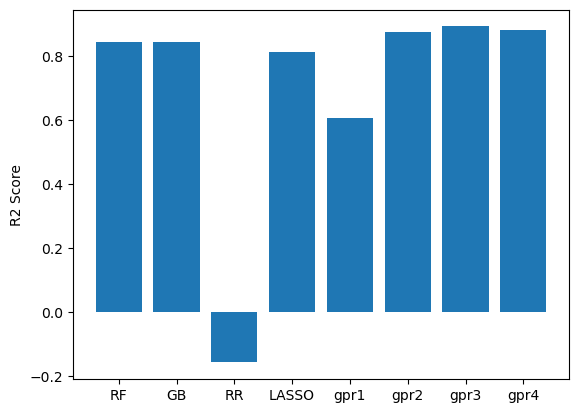

In [14]:
run_models()

In [15]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['mean_A2B', 's_X', 'X_Ra', 'X_EA', 'X_Z', 'mean_X2X', 'A_Rvdw',
       's_A', 'mean_A2X', 's_B', 'A_IEI', 'E_coh', 'A_ChiA', 'std_A2X',
       'X_IEII', 'B_Hf', 'A_ChiP', 'B_MP', 'A_BP', 'std_B2X', 'A_Z',
       'X_Kappa', 'A_EA', 'B_Ra', 'OF', 'A_CvM', 'B_Z', 'A_Kappa',
       'B_Kappa', 'X_ChiA'], dtype=object)

In [16]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]
t30_columns = ['mean_A2B', 's_X', 'X_Ra', 'X_EA', 'X_Z', 'mean_X2X', 'A_Rvdw',
       's_A', 'mean_A2X', 's_B', 'A_IEI', 'E_coh', 'A_ChiA', 'std_A2X',
       'X_IEII', 'B_Hf', 'A_ChiP', 'B_MP', 'A_BP', 'std_B2X', 'A_Z',
       'X_Kappa', 'A_EA', 'B_Ra', 'OF', 'A_CvM', 'B_Z', 'A_Kappa',
       'B_Kappa', 'X_ChiA']
data_save=data_std[t30_columns]
#data_save.to_csv("scaled_top_30.csv")

RF
R2:  0.8544736830236221
RMSE:  0.3814791173529396
---------------------------------------
GB
R2:  0.8327825009943515
RMSE:  0.4089223630539769
---------------------------------------
RR
R2:  0.558882420420459
RMSE:  0.664166831134724
---------------------------------------
LASSO
R2:  0.8162237208543873
RMSE:  0.4286913565091004
---------------------------------------
gpr1
R2:  0.6270485862653974
RMSE:  0.6106974813560332
---------------------------------------
gpr2
R2:  0.8810250374057798
RMSE:  0.3449274743974742
---------------------------------------
gpr3
R2:  0.9015695381289655
RMSE:  0.31373629351899107
---------------------------------------
gpr4
R2:  0.8940785460983719
RMSE:  0.3254557633559868
---------------------------------------
[0.8544736830236221, 0.8327825009943515, 0.558882420420459, 0.8162237208543873, 0.6270485862653974, 0.8810250374057798, 0.9015695381289655, 0.8940785460983719]


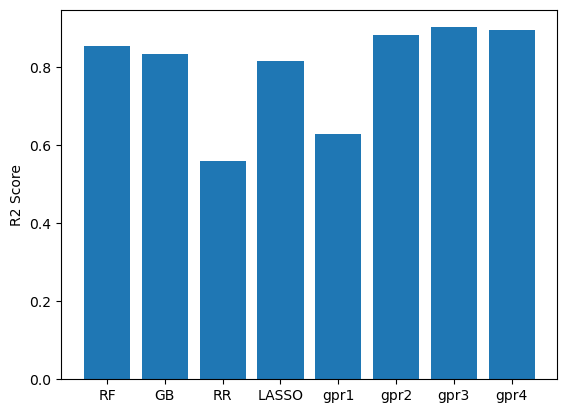

In [17]:
run_models()

In [18]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['mean_A2B', 's_X', 'X_Ra', 'X_EA', 'X_Z', 'mean_X2X', 'A_Rvdw',
       's_A', 'mean_A2X', 's_B', 'A_IEI', 'E_coh', 'A_ChiA', 'std_A2X',
       'X_IEII', 'B_Hf', 'A_ChiP', 'B_MP', 'A_BP', 'std_B2X'],
      dtype=object)

In [19]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]

RF
R2:  0.8569323163317992
RMSE:  0.37824288977877796
---------------------------------------
GB
R2:  0.8124832596331215
RMSE:  0.43303203157142833
---------------------------------------
RR
R2:  0.7701258486644427
RMSE:  0.47945192807575326
---------------------------------------
LASSO
R2:  0.825124292155084
RMSE:  0.41818142934008434
---------------------------------------
gpr1
R2:  0.7975193214683269
RMSE:  0.44997853118973696
---------------------------------------
gpr2
R2:  0.8757319179941458
RMSE:  0.3525167825875162
---------------------------------------
gpr3
R2:  0.896126946990621
RMSE:  0.32229342687895296
---------------------------------------
gpr4
R2:  0.8941719694789276
RMSE:  0.32531220469123556
---------------------------------------
[0.8569323163317992, 0.8124832596331215, 0.7701258486644427, 0.825124292155084, 0.7975193214683269, 0.8757319179941458, 0.896126946990621, 0.8941719694789276]


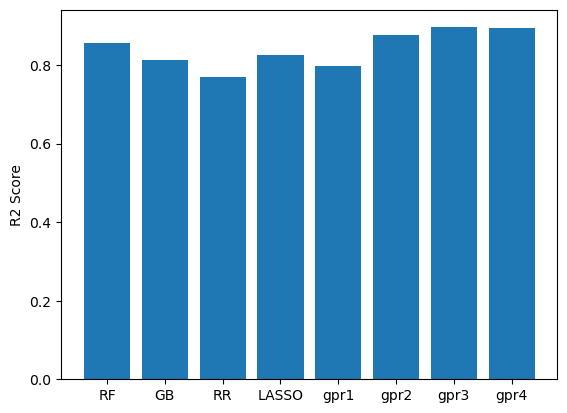

In [20]:
run_models()

In [21]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['mean_A2B', 's_X', 'X_Ra', 'X_EA', 'X_Z', 'mean_X2X', 'A_Rvdw',
       's_A', 'mean_A2X', 's_B'], dtype=object)

In [22]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]

RF
R2:  0.863858349486206
RMSE:  0.36897378025246463
---------------------------------------
GB
R2:  0.8482208014135353
RMSE:  0.3895884990428551
---------------------------------------
RR
R2:  0.7955483091843027
RMSE:  0.4521633452809916
---------------------------------------
LASSO
R2:  0.8146539335798268
RMSE:  0.43051836943407323
---------------------------------------
gpr1
R2:  0.8105890727978433
RMSE:  0.43521365695731173
---------------------------------------
gpr2
R2:  0.8760873299630276
RMSE:  0.3520123151779954
---------------------------------------
gpr3
R2:  0.8917646997618653
RMSE:  0.3289913376338877
---------------------------------------
gpr4
R2:  0.892468444018858
RMSE:  0.3279200451042021
---------------------------------------
[0.863858349486206, 0.8482208014135353, 0.7955483091843027, 0.8146539335798268, 0.8105890727978433, 0.8760873299630276, 0.8917646997618653, 0.892468444018858]


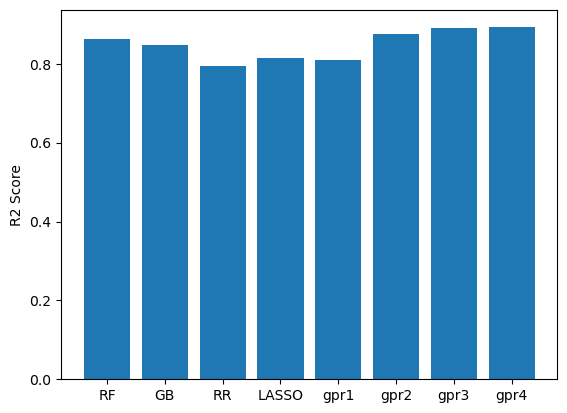

In [23]:
run_models()

# Min-Max scaling

In [24]:
data_std=d.copy()
scalerMM=MinMaxScaler()
scalerMM.fit(np.array(data[target]).reshape(-1, 1))
data_zpe_mm= scalerMM.transform(np.array(data[target]).reshape(-1, 1))
data_std[columns]= MinMaxScaler().fit_transform(d[columns])
Y = data_std[target] 
X = data_std.drop([target], axis=1)

In [25]:
correlated_features = ["A_Rc","A_Ra","A_M","A_MP","A_MV","A_MendeleevNo","A_Hf","A_Hv","B_Rc",
                       "B_Rvdw","B_M","B_BP","B_MendeleevNo","B_Hv","X_Rc","X_Rvdw","X_M","X_BP","X_MP",
                       "X_MendeleevNo","X_Hf","X_Hv","X_G","X_B","X_CvM","X_ChiP"]
data_std.drop(labels=correlated_features, axis=1, inplace=True)
print(data_std.shape)
Y = data_std[target] 
X = data_std.drop([target], axis=1)
#data_std.to_csv('Coef_a_scaled_non_corr_all.csv',index=False)

(80, 51)


In [ ]:
#data_std.to_csv("scaled_non_correlated.csv")

### Using CV technique

RF
R2:  0.8366843428191617
RMSE:  0.09547299385685744
---------------------------------------
GB
R2:  0.8299895678668714
RMSE:  0.09741019565616191
---------------------------------------
RR
R2:  0.5995735777725878
RMSE:  0.14949545640931422
---------------------------------------
LASSO
R2:  0.6372838744769733
RMSE:  0.14228203297413256
---------------------------------------
gpr1
R2:  0.760482233915717
RMSE:  0.11562067387907737
---------------------------------------
gpr2
R2:  -0.08122369647337613
RMSE:  0.24565432100098394
---------------------------------------
gpr3
R2:  0.8780365274314221
RMSE:  0.08250523784866767
---------------------------------------
gpr4
R2:  0.8544422425348714
RMSE:  0.09013309995316615
---------------------------------------
[0.8366843428191617, 0.8299895678668714, 0.5995735777725878, 0.6372838744769733, 0.760482233915717, -0.08122369647337613, 0.8780365274314221, 0.8544422425348714]


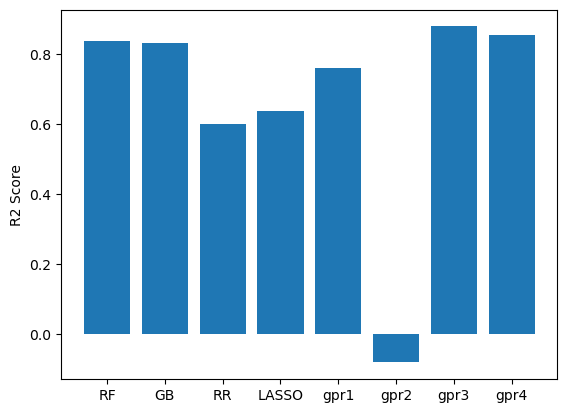

In [26]:
run_models()

## Feature selection


In [27]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

     Feature       Score
4   mean_A2B  135.546281
2        s_X   97.521570
35      X_Ra   88.664521
28      X_EA   87.903070
17       X_Z   87.153415
7   mean_X2X   77.101385
33    A_Rvdw   64.765740
0        s_A   56.272893
5   mean_A2X   54.501373
1        s_B   51.629862
20     A_IEI   41.774757
12     E_coh   36.615505
31    A_ChiA   21.738026
9    std_A2X   19.689607
25    X_IEII   19.320300
42      B_Hf   18.855125
29    A_ChiP   18.434576
36      B_MP   15.078645
37      A_BP   14.590560
10   std_B2X   13.447665
15       A_Z   13.107769
45   X_Kappa   12.936079
26      A_EA   12.189494
34      B_Ra   10.925759
14        OF    9.747189
46     A_CvM    9.336114
16       B_Z    9.046251
43   A_Kappa    8.888579
44   B_Kappa    7.588177
32    X_ChiA    7.287500


In [28]:
featureScores.nlargest(40,'Score')['Feature'].values

array(['mean_A2B', 's_X', 'X_Ra', 'X_EA', 'X_Z', 'mean_X2X', 'A_Rvdw',
       's_A', 'mean_A2X', 's_B', 'A_IEI', 'E_coh', 'A_ChiA', 'std_A2X',
       'X_IEII', 'B_Hf', 'A_ChiP', 'B_MP', 'A_BP', 'std_B2X', 'A_Z',
       'X_Kappa', 'A_EA', 'B_Ra', 'OF', 'A_CvM', 'B_Z', 'A_Kappa',
       'B_Kappa', 'X_ChiA', 'std_A2B', 'A_B', 'B_MV', 'X_MV', 'A_G',
       'X_IEI', 'B_Rho', 'B_EA', 'B_CvM', 'std_X2X'], dtype=object)

In [29]:
X=X[featureScores.nlargest(40,'Score')['Feature'].values]

RF
R2:  0.8687668408511415
RMSE:  0.08558318047240825
---------------------------------------
GB
R2:  0.8380468961186569
RMSE:  0.0950738909354326
---------------------------------------
RR
R2:  0.5703043821482148
RMSE:  0.15486279468511113
---------------------------------------
LASSO
R2:  0.6373045990625608
RMSE:  0.1422779681172317
---------------------------------------
gpr1
R2:  0.750872851071786
RMSE:  0.11791720023452384
---------------------------------------
gpr2
R2:  -0.08122357658989476
RMSE:  0.2456543073822036
---------------------------------------
gpr3
R2:  0.8878481428391716
RMSE:  0.07911700979080999
---------------------------------------
gpr4
R2:  0.8586066450578288
RMSE:  0.08883439106944492
---------------------------------------
[0.8687668408511415, 0.8380468961186569, 0.5703043821482148, 0.6373045990625608, 0.750872851071786, -0.08122357658989476, 0.8878481428391716, 0.8586066450578288]


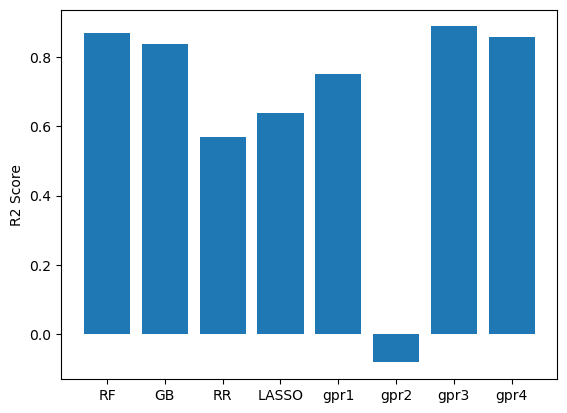

In [30]:
run_models()

In [31]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['mean_A2B', 's_X', 'X_Ra', 'X_EA', 'X_Z', 'mean_X2X', 'A_Rvdw',
       's_A', 'mean_A2X', 's_B', 'A_IEI', 'E_coh', 'A_ChiA', 'std_A2X',
       'X_IEII', 'B_Hf', 'A_ChiP', 'B_MP', 'A_BP', 'std_B2X', 'A_Z',
       'X_Kappa', 'A_EA', 'B_Ra', 'OF', 'A_CvM', 'B_Z', 'A_Kappa',
       'B_Kappa', 'X_ChiA'], dtype=object)

In [32]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]

RF
R2:  0.8249960567233413
RMSE:  0.09883039867984084
---------------------------------------
GB
R2:  0.8403634626027348
RMSE:  0.09439147652009988
---------------------------------------
RR
R2:  0.6092343623569391
RMSE:  0.14768106423205196
---------------------------------------
LASSO
R2:  0.6373045990625608
RMSE:  0.1422779681172317
---------------------------------------
gpr1
R2:  0.7604513201224326
RMSE:  0.11562813503393775
---------------------------------------
gpr2
R2:  -0.08122360078491919
RMSE:  0.2456543101307618
---------------------------------------
gpr3
R2:  0.8967562050178857
RMSE:  0.07590993331406114
---------------------------------------
gpr4
R2:  0.8635715770237415
RMSE:  0.087260773736754
---------------------------------------
[0.8249960567233413, 0.8403634626027348, 0.6092343623569391, 0.6373045990625608, 0.7604513201224326, -0.08122360078491919, 0.8967562050178857, 0.8635715770237415]


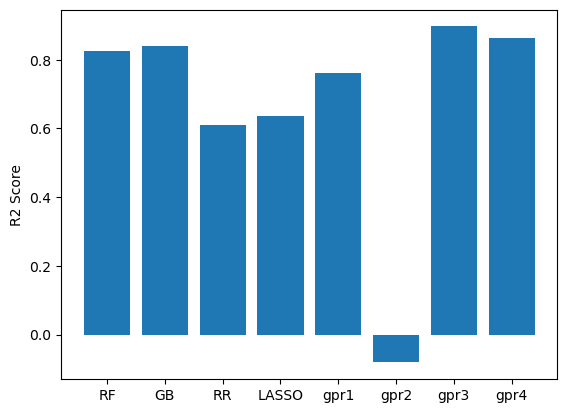

In [33]:
run_models()

In [34]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['mean_A2B', 's_X', 'X_Ra', 'X_EA', 'X_Z', 'mean_X2X', 'A_Rvdw',
       's_A', 'mean_A2X', 's_B', 'A_IEI', 'E_coh', 'A_ChiA', 'std_A2X',
       'X_IEII', 'B_Hf', 'A_ChiP', 'B_MP', 'A_BP', 'std_B2X'],
      dtype=object)

In [35]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]

RF
R2:  0.8544009866302441
RMSE:  0.09014587240579701
---------------------------------------
GB
R2:  0.8317607214227196
RMSE:  0.09690146182542728
---------------------------------------
RR
R2:  0.7827179896647283
RMSE:  0.11012312206360304
---------------------------------------
LASSO
R2:  0.6394925210709936
RMSE:  0.14184818050612527
---------------------------------------
gpr1
R2:  0.8128163841670928
RMSE:  0.10221168460558917
---------------------------------------
gpr2
R2:  -0.08122359585464212
RMSE:  0.24565430957068163
---------------------------------------
gpr3
R2:  0.8896164227020932
RMSE:  0.0784908192912864
---------------------------------------
gpr4
R2:  0.8645297551591659
RMSE:  0.08695380438079965
---------------------------------------
[0.8544009866302441, 0.8317607214227196, 0.7827179896647283, 0.6394925210709936, 0.8128163841670928, -0.08122359585464212, 0.8896164227020932, 0.8645297551591659]


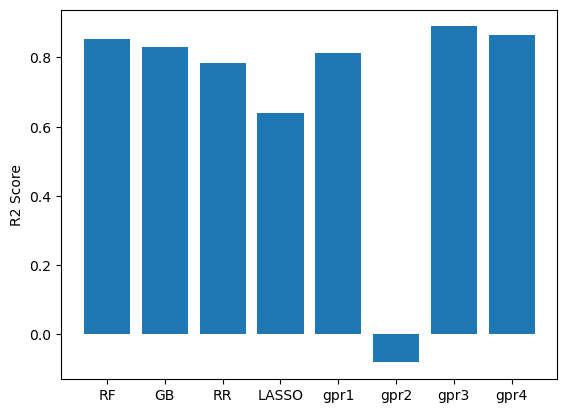

In [36]:
run_models()

In [37]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['mean_A2B', 's_X', 'X_Ra', 'X_EA', 'X_Z', 'mean_X2X', 'A_Rvdw',
       's_A', 'mean_A2X', 's_B'], dtype=object)

In [38]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]

RF
R2:  0.8475808891964914
RMSE:  0.09223300148704273
---------------------------------------
GB
R2:  0.8438159750598488
RMSE:  0.09336517925144566
---------------------------------------
RR
R2:  0.7994006484145355
RMSE:  0.10581113975908231
---------------------------------------
LASSO
R2:  0.6394925210709936
RMSE:  0.14184818050612527
---------------------------------------
gpr1
R2:  0.8277497644881024
RMSE:  0.09804976163824654
---------------------------------------
gpr2
R2:  -0.0812235506875616
RMSE:  0.2456543044396948
---------------------------------------
gpr3
R2:  0.8866130978736272
RMSE:  0.07955144542061217
---------------------------------------
gpr4
R2:  0.8601830812339335
RMSE:  0.0883377825803169
---------------------------------------
[0.8475808891964914, 0.8438159750598488, 0.7994006484145355, 0.6394925210709936, 0.8277497644881024, -0.0812235506875616, 0.8866130978736272, 0.8601830812339335]


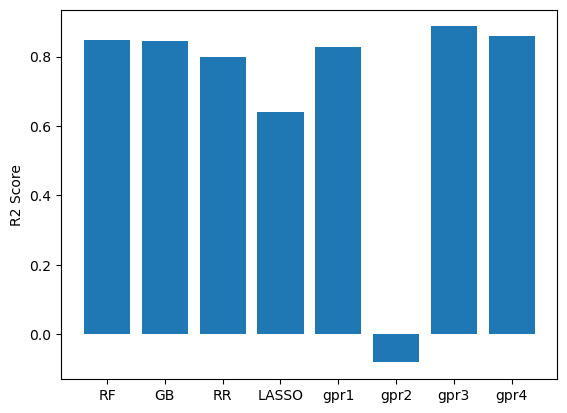

In [39]:
run_models()